In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("TrainingDataPro/facial_keypoint_detection", trust_remote_code=True)

# Print the keys and a sample to inspect the structure
print(dataset['train'].column_names)
print(dataset['train'][0])


['image_id', 'image', 'mask', 'key_points']
{'image_id': 0, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3000x4500 at 0x7FC6396BE230>, 'mask': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3000x4500 at 0x7FC6396BE110>, 'key_points': '[(1579.99, 2153.33), (2070.72, 2238.82), (1751.13, 2174.45), (1237.3, 2259.0), (1414.29, 2238.1), (1772.8, 2326.6), (1486.7, 2287.4), (1680.73, 2698.0), (1988.79, 2339.85), (1933.82, 2308.8), (1647.19, 2905.14), (1429.2, 2815.38), (1803.7, 2863.1), (1760.49, 2467.14), (1117.21, 2135.16)]'}


Empty face region for keypoints: [(6095.8, 1423.8), (6182.49, 1377.17), (6362.1, 1403.5), (5789.2, 1419.8), (5579.48, 1364.72), (5521.36, 1401.04), (5936.41, 1719.36), (6205.32, 1994.66), (5353.8, 1267.6), (5843.3, 1272.3), (6498.7, 1280.6), (6057.5, 1271.2), (5616.7, 1925.9), (5882.96, 1952.36), (5879.84, 2089.36)]
Empty face region for keypoints: [(2223.14, 2242.75), (2010.58, 2318.26), (2428.98, 2260.08), (1436.2, 2350.76), (1212.75, 2299.93), (1006.45, 2346.25), (2590.49, 2016.38), (1452.44, 2059.0), (794.58, 2110.25), (1733.93, 2845.74), (2185.48, 3252.36), (1374.49, 3279.31), (1754.15, 3236.63), (1766.96, 3481.05), (1921.9, 2045.6)]


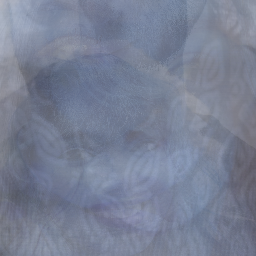

In [ ]:
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow
from datasets import load_dataset
import ast

def extract_face(image, keypoints):
    x_coords = [kp[0] for kp in keypoints]
    y_coords = [kp[1] for kp in keypoints]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    x_min = max(0, int(x_min - 0.1 * (x_max - x_min)))
    x_max = min(image.shape[1], int(x_max + 0.1 * (x_max - x_min)))
    y_min = max(0, int(y_min - 0.1 * (y_max - y_min)))
    y_max = min(image.shape[0], int(y_max + 0.1 * (y_max - y_min)))

    face = image[y_min:y_max, x_min:x_max]
    if face.size == 0:
        print(f"Empty face region for keypoints: {keypoints}")
    return face

def compute_average_face(images):
    sum_image = None
    count = 0

    for image, keypoints in images:
        face = extract_face(image, keypoints)
        if face.size == 0:
            continue
        face = cv2.resize(face, (256, 256))  # Resize for uniformity
        if sum_image is None:
            sum_image = np.zeros_like(face, dtype=np.float32)
        sum_image += face
        count += 1

    if count == 0:
        raise ValueError("No valid faces found in the dataset.")

    average_face = sum_image / count
    return cv2.convertScaleAbs(average_face)

# Load the dataset
dataset = load_dataset("TrainingDataPro/facial_keypoint_detection", trust_remote_code=True)

# Extract images and keypoints
images = []
for sample in dataset['train']:
    # Convert the PIL image to a numpy array
    image = np.array(sample['image'].convert('RGB'), dtype=np.uint8)

    # Parse the keypoints string to a list of tuples
    keypoints = ast.literal_eval(sample['key_points'])

    images.append((image, keypoints))

# Compute the average face
try:
    average_face = compute_average_face(images)
    # Display the average face
    cv2_imshow(average_face)
except ValueError as e:
    print(e)


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        return image[y:y+h, x:x+w]
    return None

def compute_average_face(images):
    sum_image = None
    count = 0

    for image in images:
        face = detect_face(image)
        if face is not None:
            face = cv2.resize(face, (256, 256))  # Resize for uniformity
            if sum_image is None:
                sum_image = np.zeros_like(face, dtype=np.float32)
            sum_image += face
            count += 1

    average_face = sum_image / count
    return cv2.convertScaleAbs(average_face)

image_paths = ["/var/tmp/S1/1.pgm", "/var/tmp/S1/2.pgm", "/var/tmp/S1/3.pgm", "/var/tmp/S1/4.pgm", "/var/tmp/S1/5.pgm", "/var/tmp/S1/6.pgm", "/var/tmp/S1/7.pgm", "/var/tmp/S2/1.pgm", "/var/tmp/S2/2.pgm", "/var/tmp/S2/3.pgm"
, "/var/tmp/S2/4.pgm", "/var/tmp/S2/5.pgm", "/var/tmp/S2/6.pgm", "/var/tmp/S2/7.pgm", "/var/tmp/S3/7.pgm", "/var/tmp/S3/6.pgm", "/var/tmp/S3/5.pgm", "/var/tmp/S3/4.pgm", "/var/tmp/S3/3.pgm", "/var/tmp/S3/2.pgm", "/var/tmp/S3/1.pgm"
, "/var/tmp/S4/7.pgm",
"/var/tmp/S5/1.pgm", "/var/tmp/S5/2.pgm", "/var/tmp/S5/3.pgm", "/var/tmp/S5/4.pgm", "/var/tmp/S5/5.pgm", "/var/tmp/S5/6.pgm", "/var/tmp/S5/7.pgm",
"/var/tmp/S6/1.pgm", "/var/tmp/S6/2.pgm", "/var/tmp/S6/3.pgm", "/var/tmp/S6/4.pgm", "/var/tmp/S6/5.pgm", "/var/tmp/S6/6.pgm", "/var/tmp/S6/7.pgm",
"/var/tmp/S7/1.pgm", "/var/tmp/S7/2.pgm", "/var/tmp/S7/3.pgm", "/var/tmp/S7/4.pgm", "/var/tmp/S7/5.pgm", "/var/tmp/S7/6.pgm", "/var/tmp/S7/7.pgm",
"/var/tmp/S8/1.pgm", "/var/tmp/S8/2.pgm", "/var/tmp/S8/3.pgm", "/var/tmp/S8/4.pgm", "/var/tmp/S8/5.pgm", "/var/tmp/S8/6.pgm", "/var/tmp/S8/7.pgm",
"/var/tmp/S9/1.pgm", "/var/tmp/S9/2.pgm", "/var/tmp/S9/3.pgm", "/var/tmp/S9/4.pgm", "/var/tmp/S9/5.pgm", "/var/tmp/S9/6.pgm", "/var/tmp/S9/7.pgm",
"/var/tmp/S10/1.pgm", "/var/tmp/S10/2.pgm", "/var/tmp/S10/3.pgm", "/var/tmp/S10/4.pgm", "/var/tmp/S10/5.pgm", "/var/tmp/S10/6.pgm", "/var/tmp/S10/7.pgm",
"/var/tmp/S11/1.pgm", "/var/tmp/S11/2.pgm", "/var/tmp/S11/3.pgm", "/var/tmp/S11/4.pgm", "/var/tmp/S11/5.pgm", "/var/tmp/S11/6.pgm", "/var/tmp/S11/7.pgm",
"/var/tmp/S12/1.pgm", "/var/tmp/S12/2.pgm", "/var/tmp/S12/3.pgm", "/var/tmp/S12/4.pgm", "/var/tmp/S12/5.pgm", "/var/tmp/S12/6.pgm", "/var/tmp/S12/7.pgm",
"/var/tmp/S13/1.pgm", "/var/tmp/S13/2.pgm", "/var/tmp/S13/3.pgm", "/var/tmp/S13/4.pgm", "/var/tmp/S13/5.pgm", "/var/tmp/S13/6.pgm", "/var/tmp/S13/7.pgm",
"/var/tmp/S14/1.pgm", "/var/tmp/S14/2.pgm", "/var/tmp/S14/3.pgm", "/var/tmp/S14/4.pgm", "/var/tmp/S14/5.pgm", "/var/tmp/S14/6.pgm", "/var/tmp/S14/7.pgm",]


images = [cv2.imread(image_path) for image_path in image_paths]
average_face = compute_average_face(images)
cv2_imshow(average_face)


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import cv2
from datasets import load_dataset
import numpy as np

# Step 1: Input the Training Pictures
def load_images_from_dataset(dataset):
    image_paths = dataset['train']['image']
    image_paths = [str(path) for path in image_paths]
    return [cv2.imread(path) for path in image_paths]


# Step 2: Dissect Each Training Picture (Face Detection)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(images):
    detected_faces = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        detected_faces.append(faces)
    return detected_faces

# Step 3: Hatting (Pre-processing)
def preprocess_images(images, size=(100, 100)):
    processed_images = []
    for img in images:
        resized_img = cv2.resize(img, size)
        processed_images.append(resized_img)
    return processed_images

# Step 4: Find the "Mean Face"
def find_mean_face(images):
    return np.mean(images, axis=0)

# Step 5: Get De-mean Faces
def get_de_mean_faces(images, mean_face):
    return images - mean_face

# Step 6: Calculate Tensor Product (Pixel-wise Multiplication)
def calculate_tensor_product(de_mean_faces):
    return np.prod(de_mean_faces, axis=0)

# Step 7: Calculate Covariance (Average Complete Analytical Relation Between Pixels)
def calculate_covariance(de_mean_faces):
    print("Shape of de_mean_faces:", de_mean_faces.shape)
    if de_mean_faces.size == 0:
        raise ValueError("de_mean_faces is empty")
    return np.cov(de_mean_faces.reshape(de_mean_faces.shape[0], -1).T)

# Load the dataset
dataset = load_dataset("TrainingDataPro/facial_keypoint_detection")

# Load images from dataset
training_images = load_images_from_dataset(dataset)

# Preprocess images
training_images_preprocessed = preprocess_images(training_images)

# Dissect Each Training Picture (Face Detection)
detected_faces = detect_faces(training_images_preprocessed)

# Find the "Mean Face"
mean_face = find_mean_face(training_images_preprocessed)

# Get De-mean Faces
de_mean_faces = get_de_mean_faces(training_images_preprocessed, mean_face)

# Calculate Tensor Product
tensor_product = calculate_tensor_product(de_mean_faces)

# Calculate Covariance
cov_matrix = calculate_covariance(de_mean_faces)


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
!pip install cmake
!pip install boost
!pip install dlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 2.2 MB/s eta 0:00:00
  Created wheel for boost: filename=boost-0.1-py3-none-any.whl size=12446 sha256=db51ca6b2143adaeae913881abdda1e1223e19363bf9a8415e2dd14fdd8476ff
  Stored in directory: /root/.cache/pip/wheels/a3/87/ab/8641d30039f2fb7605bab327a7e0608359c304ce565a1e6614
Successfully built boost


In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=2f1e63218c4a90e35c2fd1269f66d74b2ae180b14c5cf0df3e2261f607410c3b
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import face_recognition

# 通过PIL加载图片
JJ_image = face_recognition.load_image_file("/content/R.jpg")
jj_image = face_recognition.load_image_file("/content/微信图片_20240305160627.jpg")
unknown_image = face_recognition.load_image_file("/content/微信图片_20240305162953.jpg")

plt.imshow(JJ_image)
plt.title('JJ')
plt.axis('off')
plt.show()
plt.imshow(jj_image)
plt.title('jj')
plt.axis('off')
plt.show()
plt.imshow(unknown_image)
plt.title('unknown')
plt.axis('off')
plt.show()

# 获取输入图像文件中每个人脸的人脸特征，人脸特征维度为128
# 由于输入图像中可能有多张脸，因此它会返回一个特征列表。
# 默认输入图像只有一张人脸，只关心每个图像中的第一个特征，所以设置特征获取索引为0
# 建议单步看看该函数运行机制

JJ_face_encoding = face_recognition.face_encodings(JJ_image)[0]
jj_face_encoding = face_recognition.face_encodings(jj_image)[0]
unknown_face_encoding = face_recognition.face_encodings(unknown_image)[0]

RuntimeError: Error while calling cudaGetDevice(&the_device_id) in file /tmp/pip-install-ohd7xvdh/dlib_f3c2d6d1f16a4608a40cfee36fec95d3/dlib/cuda/gpu_data.cpp:204. code: 35, reason: CUDA driver version is insufficient for CUDA runtime version